## Прочитайте файлы в rdd, проведите их анализ, и расскажите, чем они отличаются 

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

import matplotlib.pyplot as plt

import requests
from joblib import load

import warnings
warnings.filterwarnings('ignore')

In [3]:
def barplot_col(data_train, data_test, col_name, cohort=False, suptitle=False):
    """для нахождения значений столбца методом .collect() и отрисовки графиков"""

    if cohort:
        L_train = lambda row: (str((int(row.split(',')[col_num]) // cohort) * cohort), 1)
        L_test = lambda row: (str((int(row.split(',')[col_num]) // cohort) * cohort), 1)
    else:
        L_train = lambda row: (row.split(',')[col_num], 1)
        L_test = lambda row: (row.split(',')[col_num], 1)
    
    col_num = [x[0] for x in enumerate(train_header.split(',')) if x[1] == col_name][0]

    train_all = data_train \
        .map(L_train) \
        .reduceByKey(lambda x, y: x + y) \
        .sortBy(lambda x: x[1], ascending=False) \
        .collect()

    col_num = [x[0] for x in enumerate(test_header.split(',')) if x[1] == col_name][0]
    test_all = data_test \
        .map(L_test) \
        .reduceByKey(lambda x, y: x + y) \
        .sortBy(lambda x: x[1], ascending=False) \
        .collect()

    train_x, train_y = zip(*train_all)
    test_x, test_y = zip(*test_all)

    # отрисовка графиков
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    
    if suptitle:
        fig.suptitle(suptitle, fontsize=16, fontweight='bold')

    ax1, ax2 = ax.flatten()

    ax1.bar(train_x, train_y, color='#FF8C80', edgecolor='#97261A')
    ax1.set_title('Train', fontsize=14, fontweight='bold')
    ax1_title_pos = ax1.title.get_position()
    ax1.title.set_position([0, ax1_title_pos[1]])
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.grid(axis='y', linewidth=.5)

    ax2.bar(test_x, test_y, color='#FF8C80', edgecolor='#97261A')
    ax2.set_title('Test', fontsize=14, fontweight='bold')
    ax2_title_pos = ax2.title.get_position()
    ax2.title.set_position([1, ax2_title_pos[1]])
    ax2.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax2.grid(axis='y', linewidth=.5)

    plt.subplots_adjust(wspace=0.3);

Узнаем количество ядер и потоков, что у нас есть:

In [4]:
!lscpu | awk '/CPU\(s\):/ {print $2; exit}'
!lscpu | awk '/Thread\(s\) per core:/ {print $4; exit}'

2
2


Создадим сессию:

In [5]:
spark = SparkSession.builder\
        .master('local[2]')\
        .appName('Lesson_2')\
        .config('spark.executor.instances', 2)\
        .config('spark.executor.memory', f'{int(12 * 1024 / 2 /1.1)}mb')\
        .config('spark.executor.cores', 1)\
        .getOrCreate()

sc = spark.sparkContext

In [6]:
#spark.stop()

Скачаем и считаем данные:

In [7]:
train_response = requests.get('https://drive.google.com/uc?id=1T2QkcyTbYZc6mRGvV7sxdmd5HsrPv_cq')
with open('train.csv', 'wb') as file:
    file.write(train_response.content)
data_train = sc.textFile('train.csv')

test_response = requests.get('https://drive.google.com/uc?id=135bI0wV4HaKbMfZeeI20HR4sc86u9lHC')
with open('test.csv', 'wb') as file:
    file.write(test_response.content)
data_test = sc.textFile('test.csv')

Значения признаков у нас такие:


* ```id```: идентификатор
* ```battery_power```: емкость батареи (mAh)
* ```blue```: поддержка Bluetooth или нет
* ```clock_speed```: скорость работы микропроцессора
* ```dual_sim```: поддержка двух SIM-карт или нет
* ```fc```: мегапиксели фронтальной камеры
* ```four_g```: поддержка 4G или нет
* ```int_memory```: внутренняя память (ГБ)
* ```m_dep```: глубина мобильного телефона (см)
* ```mobile_wt```: вес мобильного телефона
* ```n_cores```: количество ядер процессора
* ```pc```: мегапиксели основной камеры
* ```px_height```: разрешение экрана по высоте (пиксели)
* ```px_width```: разрешение экрана по ширине (пиксели)
* ```ram```: оперативная память (МБ)
* ```sc_h```: высота экрана мобильного телефона (см)
* ```sc_w```: ширина экрана мобильного телефона (см)
* ```talk_time```: время работы от одной зарядки батареи
* ```three_g```: поддержка 3G или нет
* ```touch_screen```: наличие сенсорного экрана или нет
* ```wifi```: поддержка Wi-Fi или нет.

Посмотрим на 5 строчек файлов, с которыми предстоит работать:

In [8]:
display(data_train.take(5), '', data_test.take(5))

['battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range',
 '842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1',
 '1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2',
 '563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2',
 '615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2']

''

['id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi',
 '1,1043,1,1.8,1,14,0,5,0.1,193,3,16,226,1412,3476,12,7,2,0,1,0',
 '2,841,1,0.5,1,4,1,61,0.8,191,5,12,746,857,3895,6,0,7,1,0,0',
 '3,1807,1,2.8,0,1,0,27,0.9,186,3,4,1270,1366,2396,17,10,10,0,1,1',
 '4,1546,0,0.5,1,18,1,25,0.5,96,8,20,295,1752,3893,10,0,7,1,1,0']

Сравним заголовки у train и test: 

In [9]:
train_header = data_train.first()
test_header = data_test.first()
print(f'{train_header}\n{test_header}')

battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
id,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi


у train_header есть целевая переменная *price_range* а у test_header есть *id*

In [10]:
set(train_header.split(',')) ^ set(test_header.split(','))

{'id', 'price_range'}

Раз столбцы идут в разном порядке, то для нахождения номера одного и того же столбца для train и test будут нужны разные переборы col_num (реализовано в функции)

Сносим заголовки:

In [11]:
data_train = data_train.filter(lambda row: row != train_header)
data_test = data_test.filter(lambda row: row != test_header)

Убедимся в том, что работаем с RDD:

In [12]:
type(data_train), type(data_test)

(pyspark.rdd.PipelinedRDD, pyspark.rdd.PipelinedRDD)

*PipelinedRDD* - это подкласс *RDD* в библиотеке PySpark, так что всё норм

_____
_____

А теперь по очереди сравним значения разных признаков в train и test, рисуя для них отсортированные графики распределения:

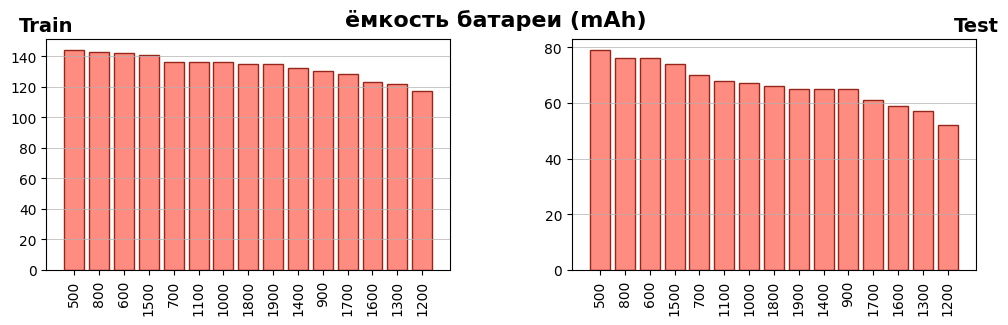

In [13]:
barplot_col(data_train, data_test, 'battery_power', cohort=100, suptitle='ёмкость батареи (mAh)')

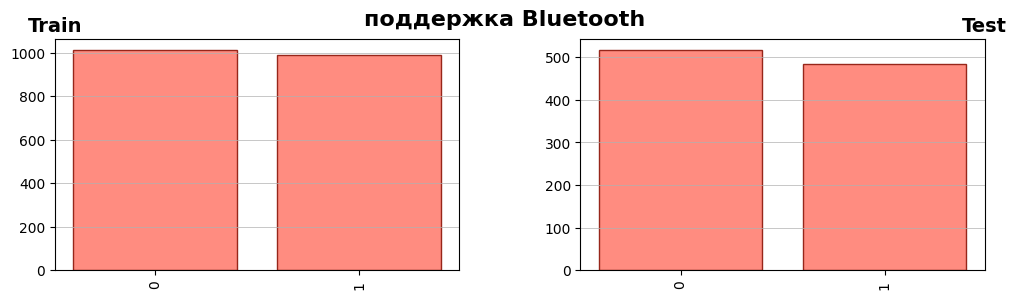

In [14]:
barplot_col(data_train, data_test, 'blue', suptitle='поддержка Bluetooth')

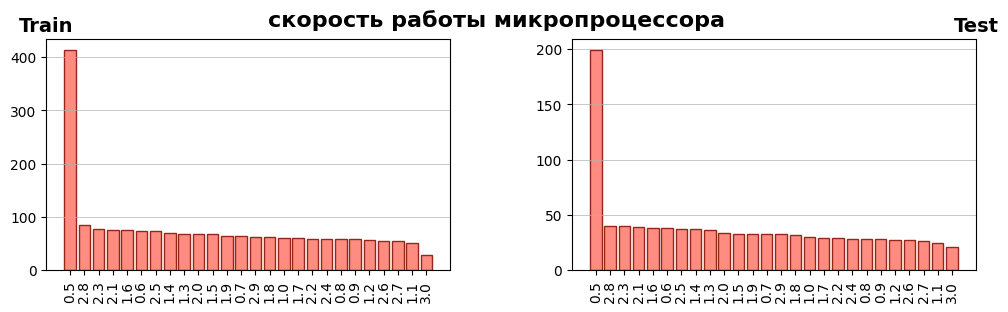

In [15]:
barplot_col(data_train, data_test, 'clock_speed', suptitle='скорость работы микропроцессора')

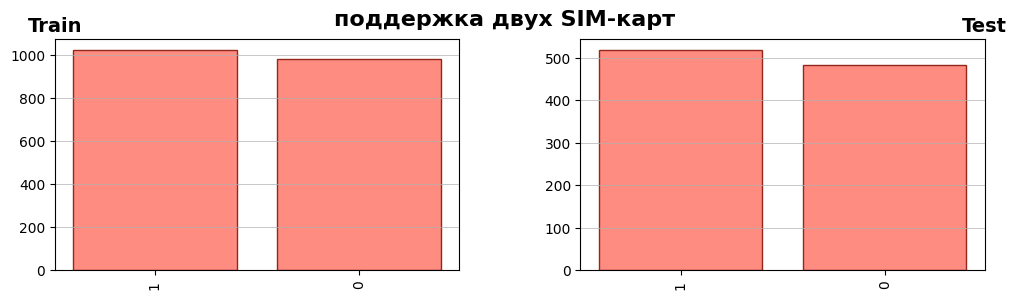

In [16]:
barplot_col(data_train, data_test, 'dual_sim', suptitle='поддержка двух SIM-карт')

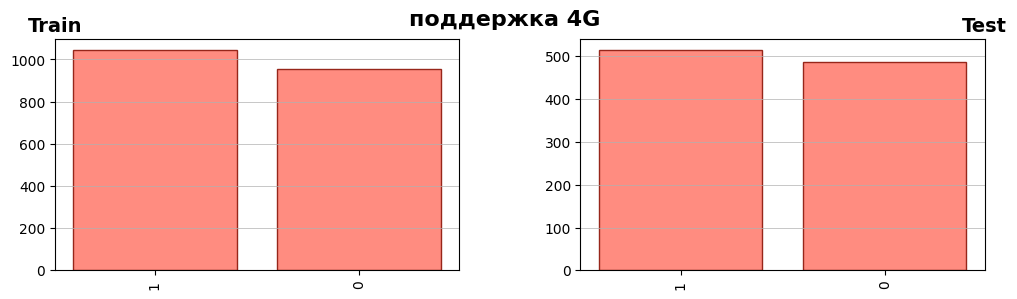

In [17]:
barplot_col(data_train, data_test, 'four_g', suptitle='поддержка 4G')

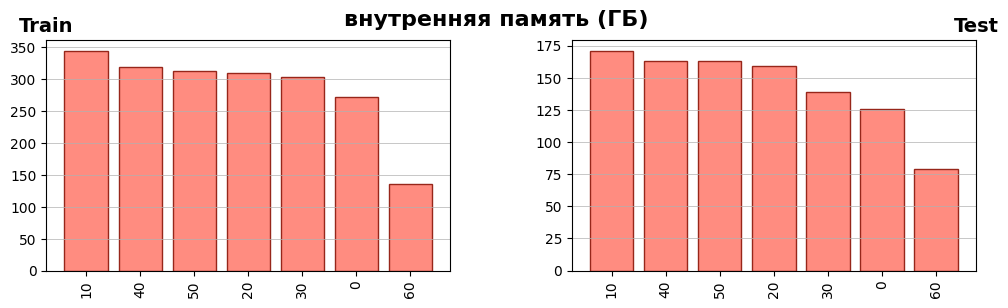

In [18]:
barplot_col(data_train, data_test, 'int_memory', cohort=10, suptitle='внутренняя память (ГБ)')

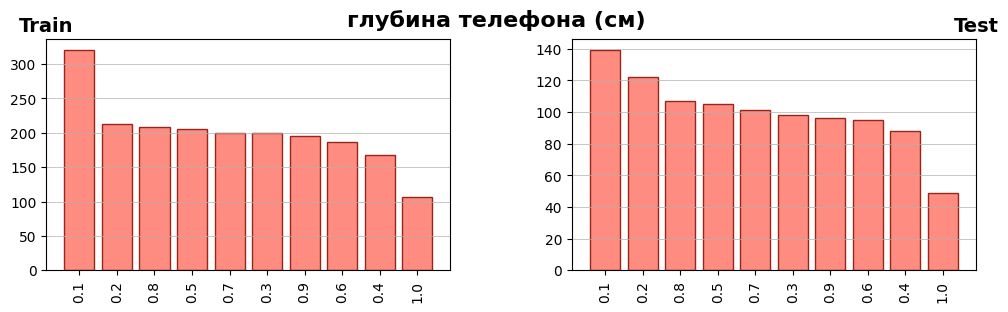

In [19]:
barplot_col(data_train, data_test, 'm_dep', suptitle='глубина телефона (см)')

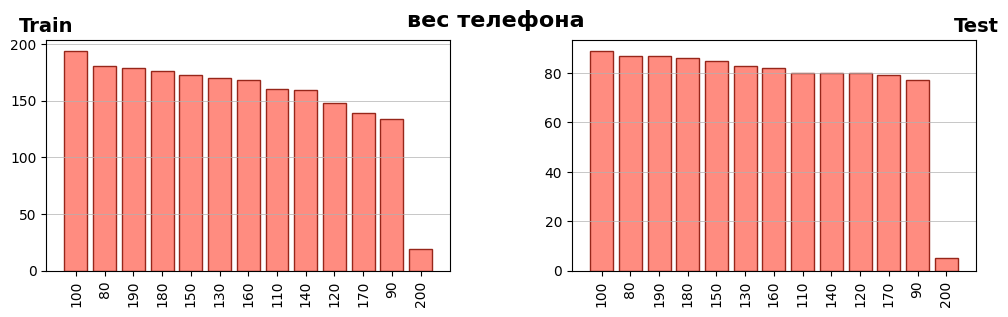

In [20]:
barplot_col(data_train, data_test, 'mobile_wt', cohort=10, suptitle='вес телефона')

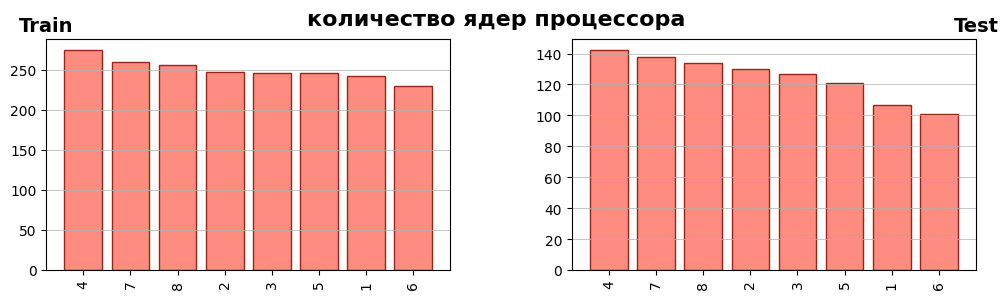

In [21]:
barplot_col(data_train, data_test, 'n_cores', suptitle='количество ядер процессора')

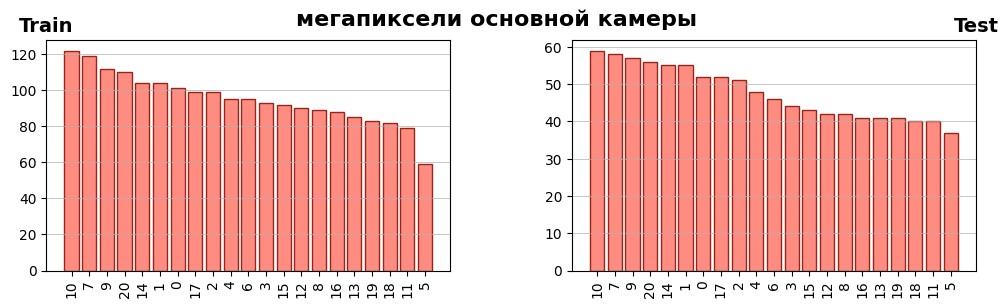

In [22]:
barplot_col(data_train, data_test, 'pc', suptitle='мегапиксели основной камеры')

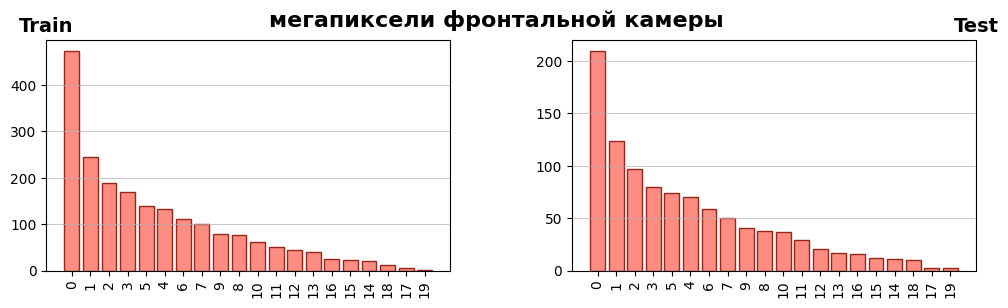

In [23]:
barplot_col(data_train, data_test, 'fc', suptitle='мегапиксели фронтальной камеры')

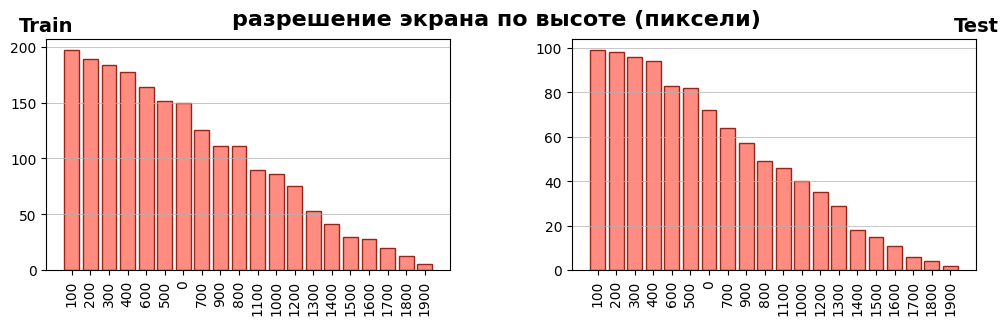

In [24]:
barplot_col(data_train, data_test, 'px_height', cohort=100, suptitle='разрешение экрана по высоте (пиксели)')

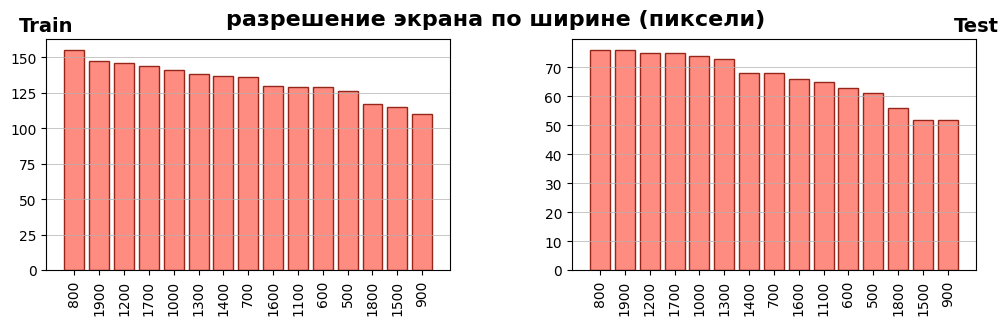

In [25]:
barplot_col(data_train, data_test, 'px_width', cohort=100, suptitle='разрешение экрана по ширине (пиксели)')

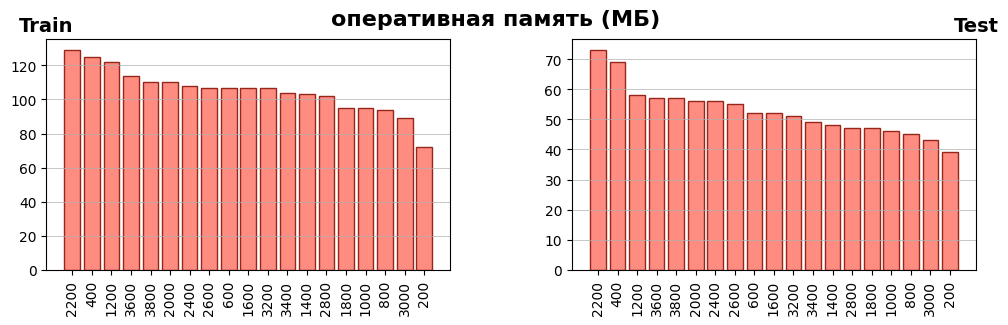

In [26]:
barplot_col(data_train, data_test, 'ram', cohort=200, suptitle='оперативная память (МБ)')

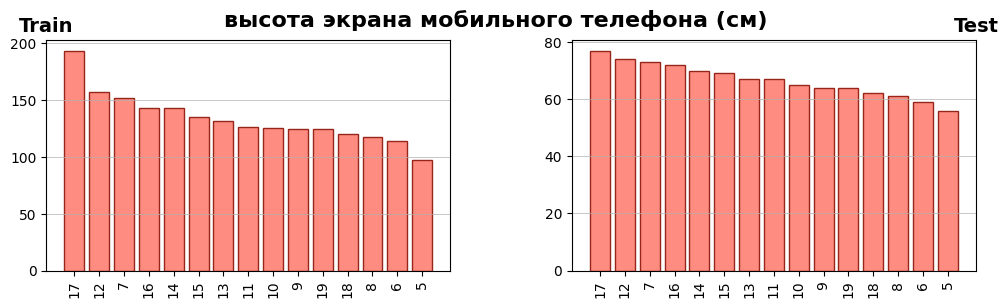

In [27]:
barplot_col(data_train, data_test, 'sc_h', suptitle='высота экрана мобильного телефона (см)')

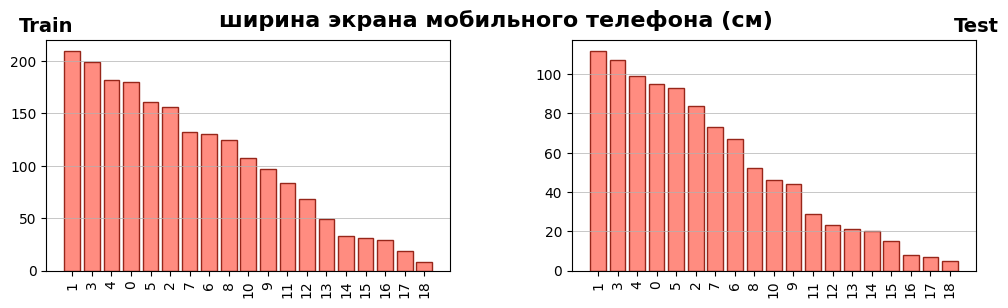

In [28]:
barplot_col(data_train, data_test, 'sc_w', suptitle='ширина экрана мобильного телефона (см)')

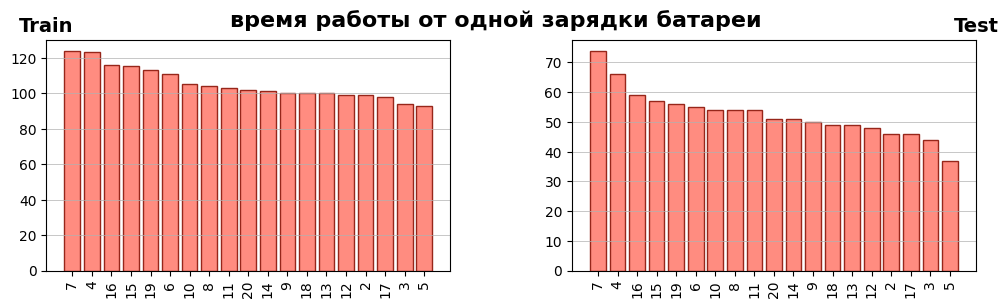

In [29]:
barplot_col(data_train, data_test, 'talk_time', suptitle='время работы от одной зарядки батареи')

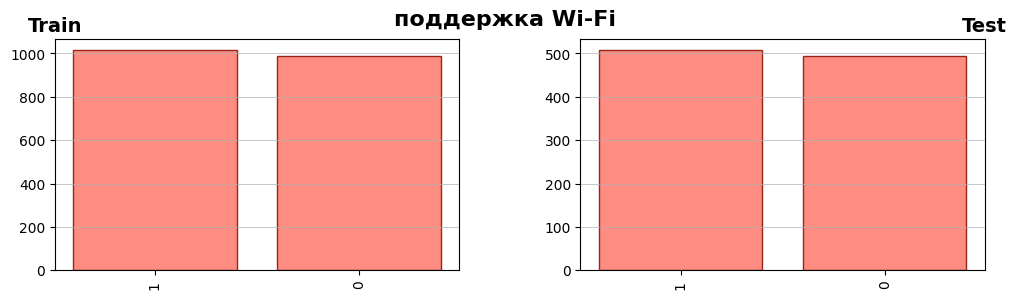

In [30]:
barplot_col(data_train, data_test, 'wifi', suptitle='поддержка Wi-Fi')

_____
_____

**Итого**: в этой работе мы: 
- скачали файлы train.csv и test.csv
- создали Spark-сессию
- с помощью метода textFile() прочитали файлы
- разобрали разницу в количестве столбцов-признаков. Выяснилось, что:
  - в тренировочных данных есть целевая переменная price_range 
  - в тестовых данных целевой переменной нет, но есть столбец с id, который смещает порядок следования остальных столбцов
- отрисовали распределение всех признаков из тренировочных и тестовых данных. 

Сравнивая расппределение значений на графиках можно сказать, что основные отличия в файлах train и test закчаются в количестве столбцов, значения же в файлах распределены более-менее одинаково.